In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
import seaborn as sns
import tensorflow as tf


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Data processing

In [ ]:
df = pd.read_csv("Dataset.csv")
tickers = df.groupby('Ticker')
dates = df.date.unique()
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

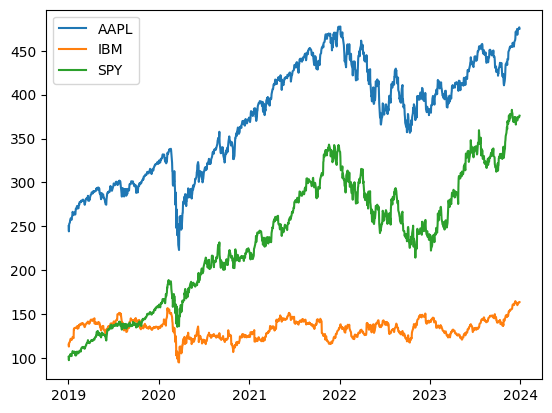

In [ ]:
for name, data in tickers:
    plt.plot(dates, data.PRC.values, '-', label = name)
plt.legend()

In [ ]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps].flatten() for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps][:, -1]
                  for idx in range(n_obs)])
    return X, y

In [ ]:
ts = {}
X = {}
y = {}
X_train_full = {}
y_train_full = {}
X_test = {}
y_test = {}
X_train = {}
y_train = {}
X_valid = {}
y_valid = {}
split_ind = {}
split_ind_2 = {}
prc = {}
for name, data in tickers:
    prc[name] = data['PRC'].iloc[0]
    data = data[['PRC']].diff().dropna()
    ts[name] = data.values#.flatten()
    X[name], y[name] = ts_split(ts[name])
    split_ind[name] = int(X[name].shape[0]*0.8)
    X_train_full[name], y_train_full[name] = X[name][:split_ind[name]], y[name][:split_ind[name]]
    X_test[name], y_test[name] = X[name][split_ind[name]:], y[name][split_ind[name]:]
    split_ind_2[name] = int(X_train_full[name].shape[0]*0.8)
    X_train[name], y_train[name] = X_train_full[name][:split_ind_2[name]], y_train_full[name][:split_ind_2[name]]
    X_valid[name], y_valid[name] = X_train_full[name][split_ind_2[name]:], y_train_full[name][split_ind_2[name]:]

## **Linear Regression**

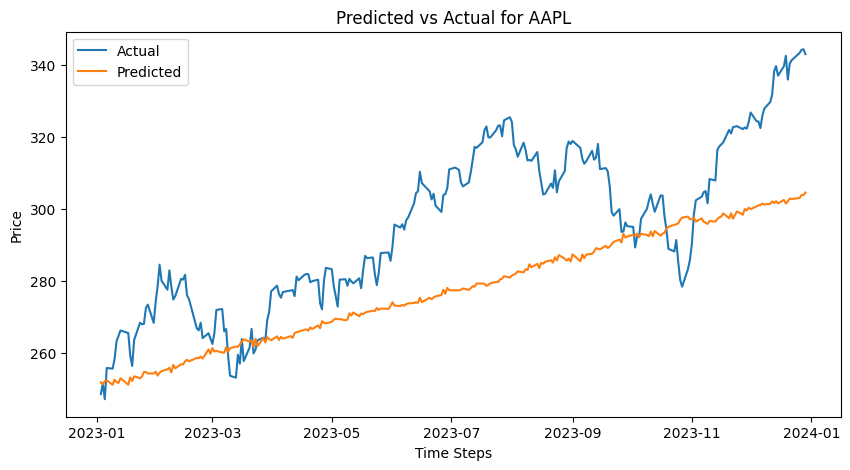

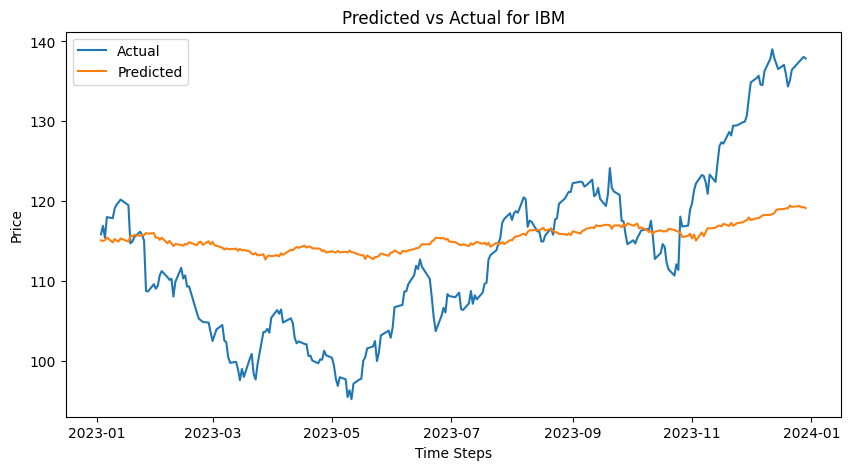

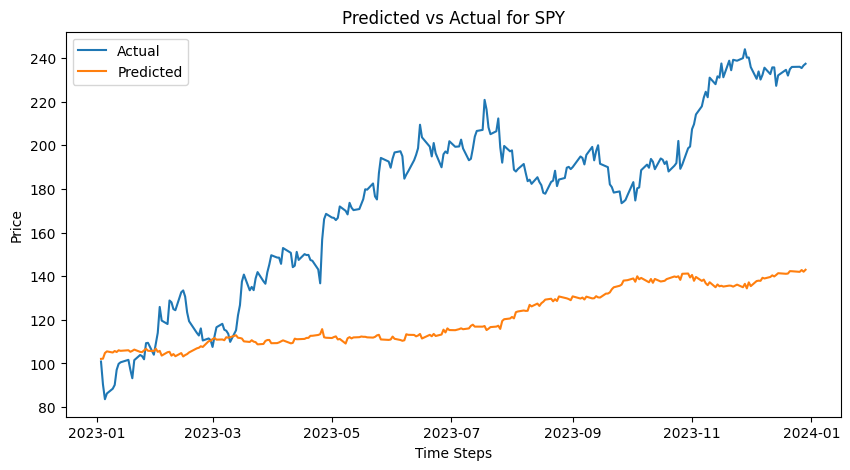

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

train_errors = {}
valid_errors = {}
y_pred_pcr = {}
test_mse = {}

for name in tickers.groups.keys():
    model = LinearRegression()

    model.fit(X_train[name], y_train[name].ravel())

    train_error = mean_squared_error(y_train[name], model.predict(X_train[name]))
    valid_error = mean_squared_error(y_valid[name], model.predict(X_valid[name]))

    train_errors[name] = train_error
    valid_errors[name] = valid_error

    diff_pred = model.predict(X_test[name]).flatten()
    restored_prices = np.cumsum(diff_pred) + prc[name]
    y_pred_pcr[name] = restored_prices

    diff_actual = y_test[name].flatten()
    y_test_pcr = np.cumsum(diff_actual) + prc[name]

    test_dates = dates[-len(y_test_pcr):]
    test_mse[name] = mean_squared_error(y_test_pcr, restored_prices)

    plt.figure(figsize=(10, 5))
    plt.plot(test_dates, y_test_pcr, label='Actual')
    plt.plot(test_dates, restored_prices, label='Predicted')
    plt.title(f"Predicted vs Actual for {name}")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [ ]:
print("Mean Squared Error for each ticker:")
for name in tickers.groups.keys():
    print(f"{name}: Train MSE = {train_errors[name]:.4f}, Valid MSE = {valid_errors[name]:.4f}, Test MSE = {test_mse[name]:.4f}")

Mean Squared Error for each ticker:
AAPL: Train MSE = 17.0068, Valid MSE = 39.0934, Test MSE = 485.5178
IBM: Train MSE = 5.1091, Valid MSE = 4.5034, Test MSE = 90.4011
SPY: Train MSE = 13.7841, Valid MSE = 34.0725, Test MSE = 3987.7247


## **ARIMA**

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


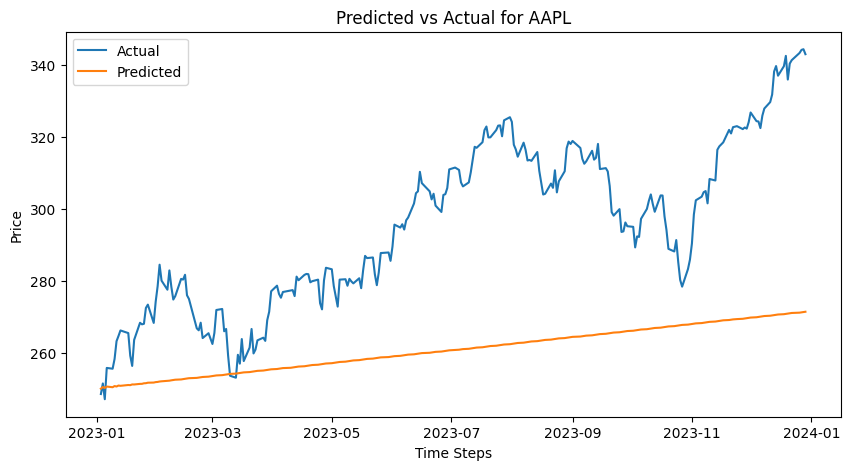

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


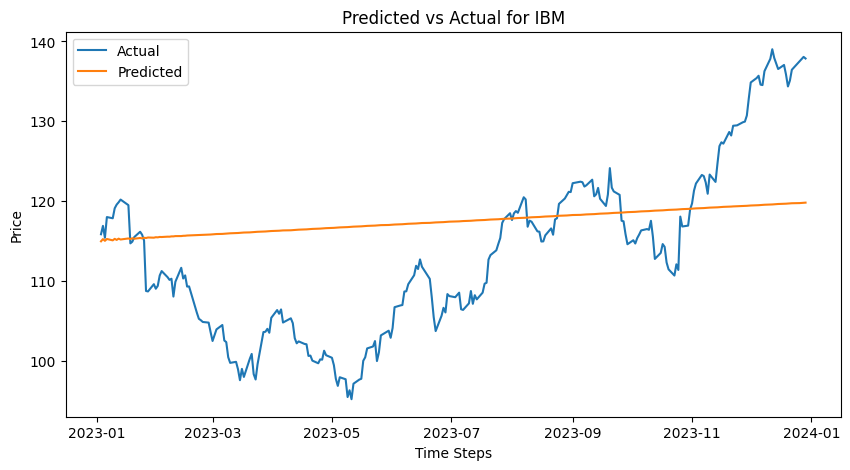

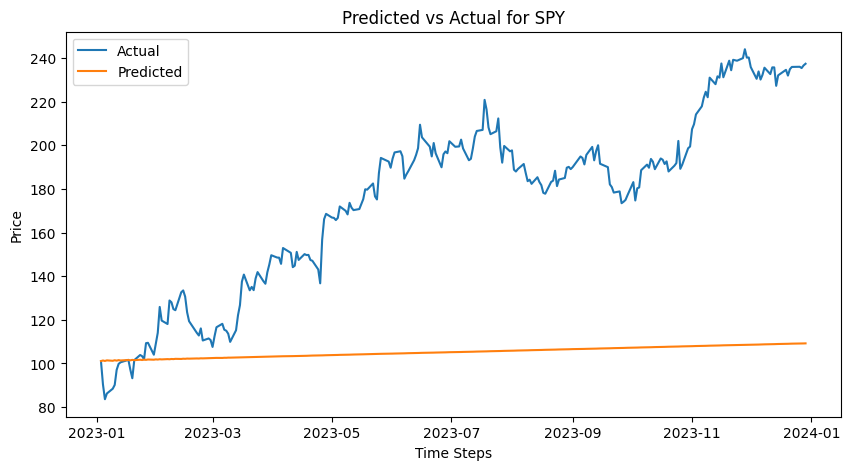

Mean Squared Error for each ticker:
AAPL: Train MSE = 18.2513, Valid MSE = 38.5675, Test MSE = 1503.5918
IBM: Train MSE = 5.3509, Valid MSE = 4.3084, Test MSE = 111.2314
SPY: Train MSE = 14.3427, Valid MSE = 33.6671, Test MSE = 6411.3121


In [61]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

train_errors = {}
valid_errors = {}
test_mse = {}
y_pred_pcr = {}

for name in tickers.groups.keys():

    train_series = np.concatenate([y_train[name].flatten(), y_valid[name].flatten()])
    model = ARIMA(train_series, order=(2, 1, 2))  # (p, d, q)
    arima_result = model.fit()

    train_pred = arima_result.predict(start=0, end=len(y_train[name]) - 1, typ="levels")
    valid_pred = arima_result.predict(start=len(y_train[name]), end=len(train_series) - 1, typ="levels")
    train_error = mean_squared_error(y_train[name], train_pred)
    valid_error = mean_squared_error(y_valid[name], valid_pred)

    train_errors[name] = train_error
    valid_errors[name] = valid_error

    diff_pred = arima_result.forecast(steps=len(y_test[name]))
    restored_prices = np.cumsum(diff_pred) + prc[name]
    y_pred_pcr[name] = restored_prices

    diff_actual = y_test[name].flatten()
    y_test_pcr = np.cumsum(diff_actual) + prc[name]


    test_mse[name] = mean_squared_error(y_test_pcr, restored_prices)
    test_dates = dates[-len(y_test_pcr):]

    plt.figure(figsize=(10, 5))
    plt.plot(test_dates, y_test_pcr, label="Actual")
    plt.plot(test_dates, restored_prices, label="Predicted")
    plt.title(f"Predicted vs Actual for {name}")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

print("Mean Squared Error for each ticker:")
for name in tickers.groups.keys():
    print(f"{name}: Train MSE = {train_errors[name]:.4f}, Valid MSE = {valid_errors[name]:.4f}, Test MSE = {test_mse[name]:.4f}")

